<a href="https://colab.research.google.com/github/arunmalik1/DSNYC103122/blob/master/OSIC_PulmoryFibrosisEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is for the OSIC pulmory fibrosis Kaggle challenge.

The aim of this competition is to predict a patient’s severity of decline in lung function based on a CT scan of their lungs. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

Patient- a unique Id for each patient (also the name of the patient's DICOM folder).

Weeks- the relative number of weeks pre/post the baseline CT (may be negative).

FVC - the recorded lung capacity in ml.

Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics.

In [3]:
#import base packages
import pandas as pd
import numpy as np
import random

#plot 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Sklearn
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)



#Data 

In [1]:
#import data from local file to google colabs
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train.csv
User uploaded file "train.csv" with length 108892 bytes


In [36]:
#saving the csv as a pandas dataframe 
df_train  = pd.read_csv('train.csv')

#EDA

In [37]:
#initial look at the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [38]:
df_train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [39]:
df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [40]:
#no missing values 
df_train.isna().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [43]:
#get the values of min and max for weeks. The negative weeks are probably 
#because some scans were taken before the project started. 
print(f"min number of weeks: {df_train['Weeks'].min()}")
print(f"max number of weeks: {df_train['Weeks'].max()}")

min number of weeks: -5
max number of weeks: 133


In [89]:
#Each patient was scanned multiple times, would be good to see how many 
#unique patients we have.
print(f"Total number of patients: {len(df_train['Patient'].unique())}")
print(f"Patient scan count: {df['Patient'].count()}")

Total number of patients: 176
Patient scan count: 1549


In [162]:
#Going to drop duplicates to get accurate graphs for the data
unique_df = df_train.drop_duplicates(subset=['Patient'])

In [165]:
#176 patients in total.
unique_df['Sex'].value_counts()

Male      139
Female     37
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Counts of Age')

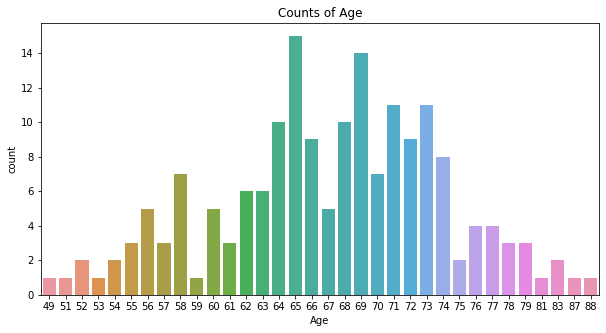

In [195]:
#taking a look at age as a whole in the dataset.
plt.figure(figsize=(10,5))
sns.countplot(x='Age', data=unique_df)
plt.title("Counts of Age")

Text(0.5, 1.0, 'Distribution of Age')

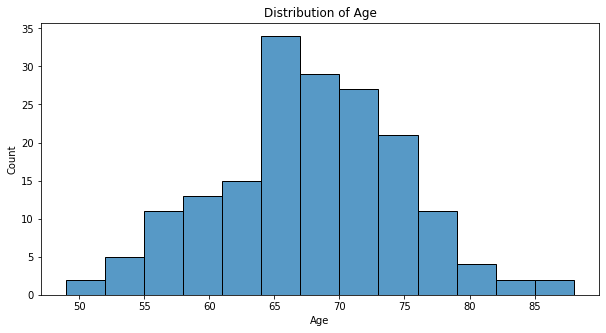

In [196]:
#Age looks to be normally disributed
plt.figure(figsize=(10,5))
sns.histplot(x='Age', data=unique_df)
plt.title("Distribution of Age")

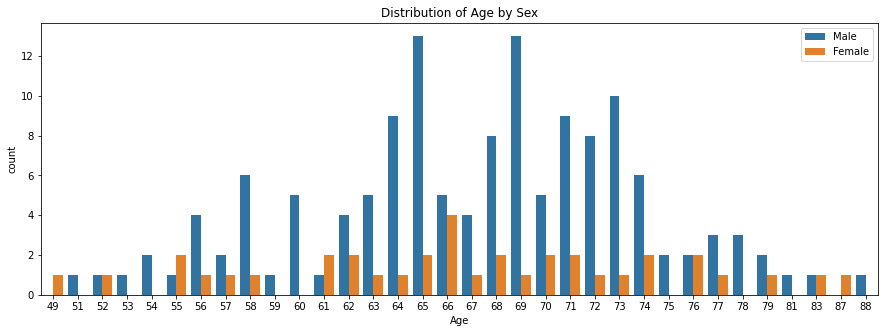

In [197]:
#Age broken down by sex, there are alot more men then women.
plt.figure(figsize=(15,5))
sns.countplot(x='Age',hue = 'Sex', data=unique_df)
plt.title("Distribution of Age by Sex")
plt.legend(loc='upper right')


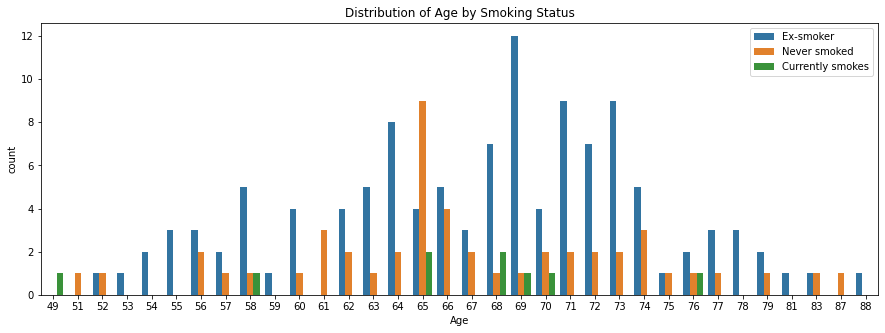

In [198]:
#Age broken down by smokers. As people get older they tend to give up smoking.
plt.figure(figsize=(15,5))
sns.countplot(x='Age',hue = 'SmokingStatus', data=unique_df)
plt.title("Distribution of Age by Smoking Status")
plt.legend(loc='upper right')

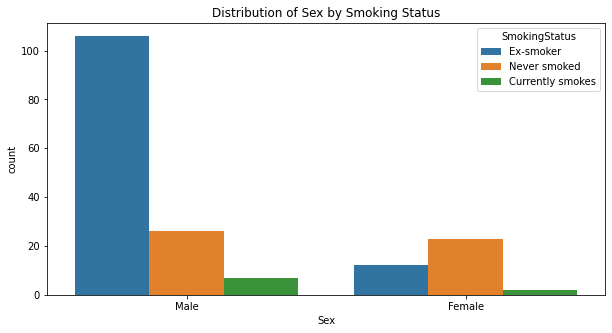

In [199]:
#plot the distribution patients by sex and smoking. Alot more male smokers.

plt.figure(figsize=(10,5))
plt.title("Distribution of Sex by Smoking Status")
sns.countplot(x='Sex',hue = 'SmokingStatus', data=unique_df)

Text(0.5, 1.0, 'FVC Distribution')

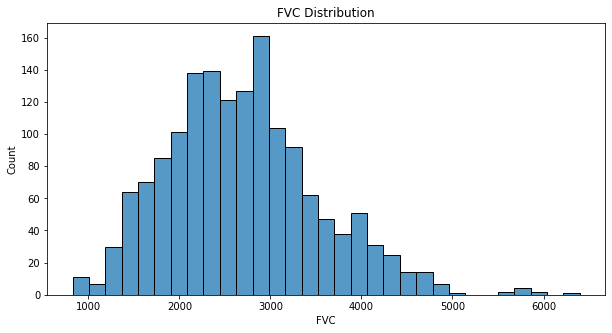

In [206]:
#FVC looks skewed, perhpas due to age and smoking
plt.figure(figsize=(10,5))
sns.histplot(x='FVC', data=df_train)
plt.title("FVC Distribution")

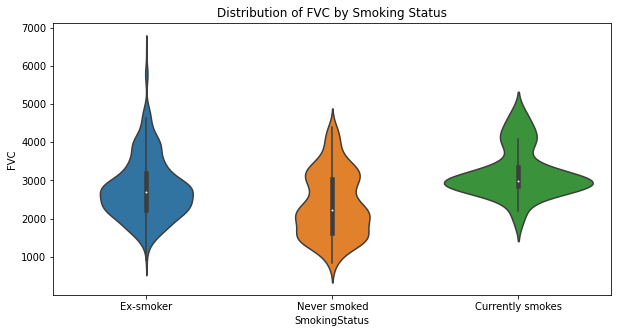

In [226]:
#Violin plot of FVC and smoking, higher is not always better.
#high FVC can be cause by gas getting trapped in lungs due to smoking.
#This is known as lung hyperinflation.

plt.figure(figsize=(10,5))
plt.title("Distribution of FVC by Smoking Status")
sns.violinplot(x='SmokingStatus', y = 'FVC', data=df_train)

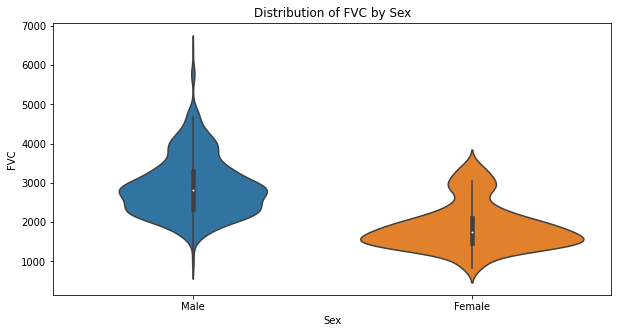

In [229]:
#Distribution of FVC by sex
plt.figure(figsize=(10,5))
plt.title("Distribution of FVC by Sex")
sns.violinplot(x='Sex', y = 'FVC', data=df_train)